In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from copy import deepcopy
from matplotlib import pyplot as plt

import os
import datetime
import time
import json
import pickle
import os
import ast
import textwrap

NAFILL = -999

In [2]:
with open("config_general.json", "r") as f:
    config_general = json.load(f)
folder_path = config_general["data_root_path"]
epis_long_to_short = config_general["epis_long_to_short"]
epis = config_general["epis"]
wks = config_general["wks"]

In [3]:
with open(folder_path + "raw_data_pool.pkl", "rb") as f:
    raw_data_pool = pickle.load(f)

In [31]:
config_specific_filename = "config_specific_cmu_two_overlap.json"

In [32]:
with open(config_specific_filename, "r") as f:
    config_specific = json.load(f)
print(config_specific)

{'label_focus': 'BDI', 'phaseI_name': 'data_phaseI_overlap', 'phaseII_name': 'data_phaseII_overlap', 'feature_col_epis_filename': 'feature_col_epis_cmu.json', 'feature_dis_col_epis_filename': 'feature_dis_col_epis_cmu.json', 'mutual_info_num_feature': 100, 'coorelation_filtering_threshold': 0.5}


In [33]:
focus_path = folder_path + "Selection_Group/" + config_specific["label_focus"] + "/"

In [34]:
df_phaseI_data = raw_data_pool[config_specific["phaseI_name"]]["data"]
df_phaseI_label = raw_data_pool[config_specific["phaseI_name"]]["label"]
df_phaseI_label = df_phaseI_label.set_index("PID")
df_phaseII_data = raw_data_pool[config_specific["phaseII_name"]]["data"]
df_phaseII_label = raw_data_pool[config_specific["phaseII_name"]]["label"]
df_phaseII_label = df_phaseII_label.set_index("PID")

In [35]:
with open(folder_path + config_specific["feature_dis_col_epis_filename"],"r") as f:
    feature_dis_col_epis = json.load(f)
with open(folder_path + config_specific["feature_col_epis_filename"],"r") as f:
    feature_col_epis = json.load(f)
with open(folder_path + "symbol_to_int_map_day.json", "r") as f:
    symbol_to_int_map_day = json.load(f)
with open(folder_path + "int_to_symbol_map_day.json", "r") as f:
    int_to_symbol_map_day = json.load(f)
with open(folder_path + "int_to_feature_map_day.json", "r") as f:
    int_to_feature_map_day = json.load(f)

In [36]:
with open(focus_path + "top_features.json", "r") as f:
    top_features = json.load(f)
with open(focus_path + "top_features_with_aggregation.json", "r") as f:
    top_features_with_aggregation = json.load(f)
    
# with open(focus_path + "top_features_raw.json", "r") as f:
#     top_features = json.load(f)
# with open(focus_path + "top_features_raw.json", "r") as f:
#     top_features_with_aggregation = json.load(f)

In [37]:
PID_list_grp1_phaseI = df_phaseI_label[df_phaseI_label["label"] & ~df_phaseI_label["BDI"].isna()].index.tolist()
PID_list_grp2_phaseI = df_phaseI_label[~df_phaseI_label["label"] & ~df_phaseI_label["BDI"].isna()].index.tolist()
PID_list_grp1_phaseII = df_phaseII_label[df_phaseII_label["label"] & ~df_phaseII_label["BDI"].isna()].index.tolist()
PID_list_grp2_phaseII = df_phaseII_label[~df_phaseII_label["label"]& ~df_phaseII_label["BDI"].isna()].index.tolist()

In [38]:
print(len(PID_list_grp1_phaseI + PID_list_grp2_phaseI)
    ,len(PID_list_grp1_phaseII + PID_list_grp2_phaseII))

68 68


In [39]:
count = 0
for wk in wks:
    for epi in epis:
        count += len(top_features_with_aggregation[wk][epi])
print(count)

157


In [14]:
def obtain_unimodal_feature_full(df_data):
    df_unimodal_asso = {}
    for wk in wks:
        df_unimodal_asso[wk] = {}
        for epi in epis:
            print(wk,epi)

            df_unimodal_asso[wk][epi] = pd.DataFrame()
#             df_buf = deepcopy(df_data)
            tfeatures = top_features[wk][epi]
            tfeatures = [x.replace("_" + wk, "") for x in tfeatures]
#             df_unimodal = deepcopy(df_data[df_data["wk"] == wk][["PID"] + tfeatures])
            df_unimodal = deepcopy(df_data[df_data["wk"] == wk][["PID"] + feature_col_epis[epi]])
            df_unimodal["PID"] = df_unimodal["PID"].astype(int)
            df_unimodal_mean = df_unimodal.groupby("PID").mean()
#             df_unimodal_mean.columns = ["mean_" + y + "_" + wk for y in tfeatures]
            df_unimodal_mean.columns = ["mean_" + y + "_" + wk for y in feature_col_epis[epi]]

            df_unimodal_std = df_unimodal.groupby("PID").std()
#             df_unimodal_std.columns = ["std_" + y + "_" + wk for y in tfeatures]
            df_unimodal_std.columns = ["std_" + y + "_" + wk for y in feature_col_epis[epi]]

            df_unimodal_mean_norm = (df_unimodal_mean - df_unimodal_mean.mean()) / df_unimodal_mean.std()
            df_unimodal_std_norm = (df_unimodal_std - df_unimodal_std.mean()) / df_unimodal_std.std()
            df_unimodal_mean_std = df_unimodal_mean_norm.merge(df_unimodal_std_norm, how = "outer", left_index=True, right_index=True)
            
            df_unimodal_asso[wk][epi] = deepcopy(df_unimodal_mean_std[top_features_with_aggregation[wk][epi]])
#             df_unimodal_asso[wk][epi] = deepcopy(df_unimodal_mean_std)


    df_unimodal_asso_combined = pd.DataFrame()
    for wk in wks:
        for epi in epis:
            if (df_unimodal_asso_combined.shape[0] == 0):
                df_unimodal_asso_combined = deepcopy(df_unimodal_asso[wk][epi])
            else:
                df_unimodal_asso_combined = df_unimodal_asso_combined.merge(df_unimodal_asso[wk][epi], how = "outer", left_index=True, right_index=True)
    return df_unimodal_asso_combined

def obtain_unimodal_feature(df_data, include_mean_std = True):
    df_unimodal_asso = {}
    for wk in wks:
        df_unimodal_asso[wk] = {}
        for epi in epis:
            print(wk,epi)

            df_unimodal_asso[wk][epi] = pd.DataFrame()
#             df_buf = deepcopy(df_data)
            tfeatures = top_features[wk][epi]
            tfeatures = [x.replace("_" + wk, "") for x in tfeatures]
            df_unimodal = deepcopy(df_data[df_data["wk"] == wk][["PID"] + tfeatures])
#             df_unimodal = deepcopy(df_data[df_data["wk"] == wk][["PID"] + feature_col_epis[epi]])
            df_unimodal["PID"] = df_unimodal["PID"].astype(int)
            df_unimodal_mean = df_unimodal.groupby("PID").mean()
            df_unimodal_mean.columns = ["mean_" + y + "_" + wk for y in tfeatures]
#             df_unimodal_mean.columns = ["mean_" + y + "_" + wk for y in feature_col_epis[epi]]

            df_unimodal_std = df_unimodal.groupby("PID").std()
            df_unimodal_std.columns = ["std_" + y + "_" + wk for y in tfeatures]
#             df_unimodal_std.columns = ["std_" + y + "_" + wk for y in feature_col_epis[epi]]
    
            df_unimodal_mean_norm = (df_unimodal_mean - df_unimodal_mean.mean()) / df_unimodal_mean.std()
            df_unimodal_std_norm = (df_unimodal_std - df_unimodal_std.mean()) / df_unimodal_std.std()
            df_unimodal_mean_std = df_unimodal_mean_norm.merge(df_unimodal_std_norm, how = "outer", left_index=True, right_index=True)
            
            if (include_mean_std):
                df_unimodal_asso[wk][epi] = deepcopy(df_unimodal_mean_std)
            else:
                df_unimodal_asso[wk][epi] = deepcopy(df_unimodal_mean_std[top_features_with_aggregation[wk][epi]])


    df_unimodal_asso_combined = pd.DataFrame()
    for wk in wks:
        for epi in epis:
            if (df_unimodal_asso_combined.shape[0] == 0):
                df_unimodal_asso_combined = deepcopy(df_unimodal_asso[wk][epi])
            else:
                df_unimodal_asso_combined = df_unimodal_asso_combined.merge(df_unimodal_asso[wk][epi], how = "outer", left_index=True, right_index=True)
    return df_unimodal_asso_combined

In [15]:
def obtain_contextual_feature_from_rule(df_data):
    df_multimodal_asso = {}
    for wk in wks:
        df_multimodal_asso[wk] = {}
        for epi in epis:
            print(wk,epi)
            ruleset1 = pd.read_csv(focus_path + "SPMF_select/" + "asso_rule_straight_" + wk + "_" + epi + ".csv")
            ruleset2 = pd.read_csv(focus_path + "SPMF_select/" + "asso_rule_nostraight_" + wk + "_" + epi + ".csv")
            ruleset = pd.concat([ruleset1, ruleset2])
            ruleset.reset_index(drop = True, inplace = True)
            ruleset["X"] = ruleset["X"].apply(lambda x : ast.literal_eval(x))
            ruleset["Y"] = ruleset["Y"].apply(lambda x : ast.literal_eval(x))

            df_multimodal_asso[wk][epi] = pd.DataFrame()
            df_buf = deepcopy(df_data)

            for rule_idx, rule in ruleset.iterrows():
                index_flag = True
                for x in rule["X"]:
                    dis_label_col = int_to_symbol_map_day[x][:-2] 
                    dis_label = int_to_symbol_map_day[x][-1]
                    index_flag = index_flag & (df_buf[dis_label_col] == dis_label)
                feature_columns = [int_to_feature_map_day[y] for y in rule["Y"]]
                feature_columns_name = [y + "_" + wk + "_" + epi + "_rule" + str(rule_idx) for y in feature_columns]

                df_multimodal = df_buf[index_flag][["PID"] + feature_columns]
                df_multimodal_mean = df_multimodal.groupby("PID").mean()
                df_multimodal_mean.columns = ["mean_" + y for y in feature_columns_name]
                
                df_multimodal_std = df_multimodal.groupby("PID").std()
                df_multimodal_std.columns = ["std_" + y for y in feature_columns_name]
                
                df_multimodal_mean_norm = (df_multimodal_mean - df_multimodal_mean.mean()) / df_multimodal_mean.std()
                df_multimodal_std_norm = (df_multimodal_std - df_multimodal_std.mean()) / df_multimodal_std.std()
            
                df_multimodal_mean_std = df_multimodal_mean_norm.merge(df_multimodal_std_norm, how = "outer", left_index=True, right_index=True)
    #             df_multimodal_mean_std = deepcopy(df_multimodal_mean)
                df_multimodal_mean_std = (df_multimodal_mean_std-df_multimodal_mean_std.mean())/df_multimodal_mean_std.std()
                if (df_multimodal_asso[wk][epi].shape[0] == 0):
                    df_multimodal_asso[wk][epi] = deepcopy(df_multimodal_mean_std)
                else:
                    df_multimodal_asso[wk][epi] = df_multimodal_asso[wk][epi].merge(df_multimodal_mean_std, how = "outer", left_index=True, right_index=True)
    #         df_multimodal_features[wk][epi] = deepcopy(df_multimodal_asso[wk][epi].columns)

    df_multimodal_asso_combined = pd.DataFrame()
    for wk in wks:
        for epi in epis:
            if (df_multimodal_asso_combined.shape[0] == 0):
                df_multimodal_asso_combined = deepcopy(df_multimodal_asso[wk][epi])
            else:
                df_multimodal_asso_combined = df_multimodal_asso_combined.merge(df_multimodal_asso[wk][epi], how = "outer", left_index=True, right_index=True)
    return df_multimodal_asso_combined

In [40]:
df_unimodal_asso_combined_phaseI = obtain_unimodal_feature(df_phaseI_data,include_mean_std=False)
df_unimodal_asso_combined_phaseII = obtain_unimodal_feature(df_phaseII_data,include_mean_std=False)
# df_unimodal_asso_combined_phaseI = obtain_unimodal_feature_full(df_phaseI_data)
# df_unimodal_asso_combined_phaseII = obtain_unimodal_feature_full(df_phaseII_data)
df_unimodal_asso_combined_phaseI = df_unimodal_asso_combined_phaseI.loc[df_phaseI_label[~df_phaseI_label["BDI"].isna()].index]
df_unimodal_asso_combined_phaseII = df_unimodal_asso_combined_phaseII.loc[df_phaseII_label[~df_phaseII_label["BDI"].isna()].index]
df_unimodal_asso_combined_phaseI.to_csv(focus_path + "X_unimodal_phaseI.csv")
df_unimodal_asso_combined_phaseII.to_csv(focus_path + "X_unimodal_phaseII.csv")

wkdy mo
wkdy af
wkdy ev
wkdy ni
wkend mo
wkend af
wkend ev
wkend ni
wkdy mo
wkdy af
wkdy ev
wkdy ni
wkend mo
wkend af
wkend ev
wkend ni


In [41]:
df_multimodal_asso_combined_phaseI = obtain_contextual_feature_from_rule(df_phaseI_data)
df_multimodal_asso_combined_phaseII = obtain_contextual_feature_from_rule(df_phaseII_data)
df_multimodal_asso_combined_phaseI = df_multimodal_asso_combined_phaseI.loc[df_phaseI_label[~df_phaseI_label["BDI"].isna()].index]
df_multimodal_asso_combined_phaseII = df_multimodal_asso_combined_phaseII.loc[df_phaseII_label[~df_phaseII_label["BDI"].isna()].index]
df_multimodal_asso_combined_phaseI.to_csv(focus_path + "X_contextual_phaseI.csv")
df_multimodal_asso_combined_phaseII.to_csv(focus_path + "X_contextual_phaseII.csv")

wkdy mo
wkdy af
wkdy ev
wkdy ni
wkend mo
wkend af
wkend ev
wkend ni
wkdy mo
wkdy af
wkdy ev
wkdy ni
wkend mo
wkend af
wkend ev
wkend ni


# Train & Test

In [19]:
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn import tree
from sklearn import svm
from sklearn import ensemble
from sklearn import linear_model
import sklearn
import xgboost

In [20]:
def get_clf(ctype, n_estimators = 10, max_depth = -1, max_leaf_nodes = -1, C = -1):
    if (ctype == "adaboost"):
        if (max_depth == -1):
            clf = ensemble.AdaBoostClassifier(n_estimators = n_estimators,
                                          base_estimator = tree.DecisionTreeClassifier(
#                                               max_depth= 5),
                                              max_leaf_nodes = max_leaf_nodes),
                                          learning_rate = 0.001)
        else:
            clf = ensemble.AdaBoostClassifier(n_estimators = n_estimators,
                                          base_estimator = tree.DecisionTreeClassifier(
                                              max_depth= max_depth),
#                                               max_leaf_nodes = max_leaf_nodes),
                                          learning_rate = 0.001)
    elif (ctype == "svm"):
        clf = svm.SVC(kernel='rbf', C=C)
    elif (ctype == "dt"):
        if (max_depth == -1):
            clf = tree.DecisionTreeClassifier(max_leaf_nodes = max_leaf_nodes)
        else:
            clf = tree.DecisionTreeClassifier(max_depth = max_depth)
    return clf

def train_test(ctype, X,X_II,Y,Y_II,n_estimators = 10, max_depth = -1, max_leaf_nodes = -1, C = -1, ablation = False):
    clf = get_clf(ctype, n_estimators, max_depth, max_leaf_nodes, C)

    results = {}
    iter_round = 0

    XX = deepcopy(X)
    init = 1

    importance_index = range(len(XX.columns))
    while (True):
        iter_round += 1
        print(XX.shape)
        train_acc = []
        test_acc = []
        y_pred_list = []
        y_test_list = []
        loo = LeaveOneOut()

        for train_index, test_index in loo.split(XX):
            X_train, X_test = XX.iloc[train_index,:], XX.iloc[test_index,:]
            Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
            a = clf.fit(X_train,Y_train)
            y_pred = a.predict(X_test)
            y_pred_list.append(y_pred[0])
            y_test_list.append(Y_test.iloc[0])
            train_acc.append(accuracy_score(a.predict(X_train),Y_train))
            test_acc.append(accuracy_score(y_pred,Y_test))
            
        # retrain to obtain a subset feature
        confusion_mx = confusion_matrix(y_test_list,y_pred_list)
        results[iter_round] = {}
        results[iter_round]["train_acc"] = np.mean(train_acc)
        results[iter_round]["test_acc"] = np.mean(test_acc)
        results[iter_round]["confusion_matrix"] = deepcopy(confusion_mx)
        results[iter_round]["test_acc_bal"] = balanced_accuracy_score(y_true = y_test_list,
                                                                      y_pred = y_pred_list)

        a = clf.fit(XX,Y)
        # ablation
        if (ctype == "adaboost" and not ablation):
            importance = a.feature_importances_
            importance_index_new = np.array([idx for idx, x in enumerate(importance) if x > 0])
            if (init == 1):
                init = 0
                for ite in range(10):
                    b = clf.fit(XX,Y)
                    print(len(importance_index_new), end=", ")
                    importance = b.feature_importances_
                    importance_index_new_add = np.array([idx for idx, x in enumerate(importance) if x > 0])
                    importance_index_new = np.array(list(set(importance_index_new).union(set(importance_index_new_add))))
            print(len(importance_index_new))

        else:
            importance_index_new = importance_index
        if (len(importance_index) == 1 or len(importance_index_new) == len(importance_index)):
#             if (len(importance_index) == 1):
#                 y_pred_phaseII = a.predict(X_II.fillna(NAFILL)[np.array(XX.columns.tolist())[importance_index]])
#             else:
            y_pred_phaseII = a.predict(X_II.fillna(NAFILL)[np.array(XX.columns.tolist())[importance_index_new]])
            results[iter_round]["test_acc_phaseII"] = accuracy_score(Y_II,y_pred_phaseII)
            results[iter_round]["test_acc_bal_phaseII"] = balanced_accuracy_score(y_true = Y_II,
                                                                                  y_pred = y_pred_phaseII)
            results[iter_round]["confusion_matrix_phaseII"] = confusion_matrix(Y_II,y_pred_phaseII)
            print("train acc phase1: ", results[iter_round]["train_acc"],
                  "test acc phase1: ", results[iter_round]["test_acc"], " ", results[iter_round]["test_acc_bal"],
                  "phase2: ", results[iter_round]["test_acc_phaseII"], " ", results[iter_round]["test_acc_bal_phaseII"])
            break
        else:
            results[iter_round]["importance_feature"] = deepcopy(np.array(XX.columns.tolist())[importance_index_new])
            print(importance_index_new)
            importance_index = deepcopy(importance_index_new)
            XX = X[np.array(XX.columns.tolist())[importance_index]]
            print("train acc ", results[iter_round]["train_acc"],
                  " test acc ", results[iter_round]["test_acc"],
                  " test acc bal ", results[iter_round]["test_acc_bal"])
    return results

## Unimodal Filtered

In [42]:
X_phaseI_unimodal = pd.read_csv(focus_path + "X_unimodal_phaseI.csv")
X_phaseI_unimodal["PID"] = X_phaseI_unimodal["PID"].astype(int)
X_phaseI_unimodal = X_phaseI_unimodal.set_index("PID")
Y_phaseI = df_phaseI_label[~df_phaseI_label["BDI"].isna()]["label"]
X_phaseII_unimodal = pd.read_csv(focus_path + "X_unimodal_phaseII.csv")
X_phaseII_unimodal["PID"] = X_phaseII_unimodal["PID"].astype(int)
X_phaseII_unimodal = X_phaseII_unimodal.set_index("PID")
Y_phaseII = df_phaseII_label[~df_phaseII_label["BDI"].isna()]["label"]

In [43]:
X_phaseI_unimodal.shape

(68, 157)

In [217]:
df = (X_phaseI_unimodal.iloc[:,:8].fillna(NAFILL))#.apply(lambda x : x.astype(int))
df = df.rename({x:"f" + str(y + 1) for y, x in enumerate(list(X_phaseII_unimodal.columns))}, axis = 1)
df = df.merge(pd.DataFrame(Y_phaseI), left_index = True, right_index = True)
df = df.applymap(lambda x : np.abs(round(x,5)))
# df = df.rename({"label_I":"class"}, axis = 1)
df = df.sort_values("label_I")
df["class"] = df["label_I"].apply(lambda x : "pos" if x else "neg")
df.drop("label_I",axis=1,inplace=True)
df.to_csv(focus_path + "cmu_phaseI.csv",index = False)

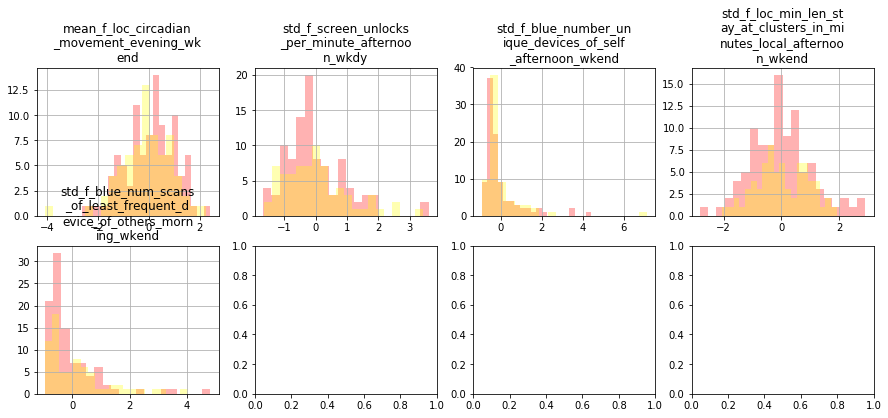

In [50]:
for i, col in enumerate(list(a)):
    j = i % 8
    if (j == 0):
        if (i > 0):
            plt.tight_layout()
            plt.show()
        fig, axes = plt.subplots(ncols = 4, nrows = 2, figsize = (15,6))
    ax = axes[j//4][j%4]
#     X_phaseI_unimodal.loc[Y_phaseI.index[Y_phaseI]][col].hist(ax = ax, alpha = 0.3, color = "blue", label = "cmu-nodep", bins = 20)
#     X_phaseI_unimodal.loc[Y_phaseI.index[~Y_phaseI]][col].hist(ax = ax, alpha = 0.3, color = "green", label = "cmu-dep", bins = 20)
    X_phaseII_unimodal.loc[Y_phaseII.index[Y_phaseII]][col].hist(ax = ax, alpha = 0.3, color = "red", label = "uw-nodep", bins = 20)
    X_phaseII_unimodal.loc[Y_phaseII.index[~Y_phaseII]][col].hist(ax = ax, alpha = 0.3, color = "yellow", label = "uw-dep", bins = 20)
#     ax.legend()
    ax.set_title("\n".join(textwrap.wrap(col,20)))

In [33]:
training_unimoal_results_depth_I = deepcopy(training_unimoal_results_depth)

In [27]:
training_unimoal_results_depth_II = deepcopy(training_unimoal_results_depth)

In [34]:
training_unimoal_results_depth_I[10][3][1]

{'confusion_matrix': array([[33, 23],
        [19, 62]], dtype=int64),
 'importance_feature': array(['std_f_screen_unlocks_per_minute_afternoon_wkdy',
        'std_f_blue_num_scans_of_least_frequent_device_of_others_morning_wkend',
        'std_f_loc_min_len_stay_at_clusters_in_minutes_local_afternoon_wkend',
        'std_f_blue_number_unique_devices_of_self_afternoon_wkend',
        'mean_f_loc_circadian_movement_evening_wkend'], dtype='<U72'),
 'test_acc': 0.6934306569343066,
 'train_acc': 0.8569665092314297}

In [35]:
a = set(training_unimoal_results_depth_I[10][3][1]["importance_feature"])

In [29]:
b = set(training_unimoal_results_depth_II[10][4][7]["importance_feature"])

In [36]:
features_from_two_phases = list(a.union(b))

In [54]:
X_phaseI_unimodal = X_phaseI_unimodal[list(a)]

In [51]:
X_phaseII_unimodal = X_phaseII_unimodal[list(a)]

In [63]:
training_unimoal_results_depth

{1: {1: {1: {'confusion_matrix': array([[34, 22],
           [22, 59]], dtype=int64),
    'importance_feature': array(['std_f_screen_unlocks_per_minute_afternoon_wkdy'], dtype='<U71'),
    'test_acc': 0.6788321167883211,
    'test_acc_bal': 0.6677689594356261,
    'train_acc': 0.7154358093602403},
   2: {'confusion_matrix': array([[34, 22],
           [22, 59]], dtype=int64),
    'confusion_matrix_phaseII': array([[27, 21],
           [51, 51]], dtype=int64),
    'test_acc': 0.6788321167883211,
    'test_acc_bal': 0.6677689594356261,
    'test_acc_bal_phaseII': 0.53125,
    'test_acc_phaseII': 0.52,
    'train_acc': 0.7154358093602403}}}}

In [37]:
training_unimoal_results_depth = {}
training_unimoal_results_leaf = {}
for n_estimators in [5]:
    training_unimoal_results_depth[n_estimators] = {}
    training_unimoal_results_leaf[n_estimators] = {}
    print("depth")
    for max_depth in [2,3,4]:
#     for max_depth in [2]:
        print(n_estimators,max_depth)
        r = train_test("adaboost",
                       X_phaseI_unimodal.fillna(NAFILL),
                       X_phaseII_unimodal.fillna(NAFILL),
                       Y_phaseI,
                       Y_phaseII,
                       n_estimators=n_estimators,
                       max_depth=max_depth)
        training_unimoal_results_depth[n_estimators][max_depth] = deepcopy(r)
    print("leaf")
    for max_leaf in [3,4,5,6,7,8]:
#     for max_leaf in [1]:
        print(n_estimators,max_leaf)
        r = train_test("adaboost",
                       X_phaseI_unimodal.fillna(NAFILL),
                       X_phaseII_unimodal.fillna(NAFILL),
                       Y_phaseI,
                       Y_phaseII,
                       n_estimators=n_estimators,
                       max_leaf_nodes=max_leaf)
        training_unimoal_results_leaf[n_estimators][max_leaf] = deepcopy(r)
# with open(focus_path + "unimodal_train_result_trainI_testII.pkl", "wb") as f:
#     pickle.dump({"depth":training_unimoal_results_depth,"leaf":training_unimoal_results_leaf},f)

depth
5 2
(68, 152)
[  4 136  10 107  74  14  50 114  53]
train acc  0.8309920983318702  test acc  0.5147058823529411  test acc bal  0.4734848484848485
(68, 9)
[0 4 6 7 8]
train acc  0.8129938542581212  test acc  0.5294117647058824  test acc bal  0.47537878787878785
(68, 5)
[0 1 2 3]
train acc  0.8107989464442494  test acc  0.75  test acc bal  0.731060606060606
(68, 4)
train acc phase1:  0.8088235294117647 test acc phase1:  0.75   0.731060606060606 phase2:  0.6029411764705882   0.544263775971093
5 3
(68, 152)
[  4 136  10 107  74  14  50 114  53  60]
train acc  0.9293239683933274  test acc  0.5147058823529411  test acc bal  0.4640151515151515
(68, 10)
[1 3 4 5 6 7 8 9]
train acc  0.9198858647936787  test acc  0.6617647058823529  test acc bal  0.625
(68, 8)
[1 2 4 5 6 7]
train acc  0.9212028094820017  test acc  0.6911764705882353  test acc bal  0.6666666666666667
(68, 6)
train acc phase1:  0.9135206321334505 test acc phase1:  0.7941176470588235   0.7651515151515151 phase2:  0.5441176470

In [43]:
training_unimoal_results_depth = {}
training_unimoal_results_leaf = {}
for n_estimators in [5]:
    training_unimoal_results_depth[n_estimators] = {}
    training_unimoal_results_leaf[n_estimators] = {}
    print("depth")
    for max_depth in [2,3,4]:
        print(n_estimators,max_depth)
        r = train_test("adaboost",
                       X_phaseII_unimodal.fillna(NAFILL),
                       X_phaseI_unimodal.fillna(NAFILL),
                       Y_phaseII,
                       Y_phaseI,
                       n_estimators=n_estimators,
                       max_depth=max_depth)
        training_unimoal_results_depth[n_estimators][max_depth] = deepcopy(r)
    print("leaf")
    for max_leaf in [3,4,5,6,7,8]:
        print(n_estimators,max_leaf)
        r = train_test("adaboost",
                       X_phaseII_unimodal.fillna(NAFILL),
                       X_phaseI_unimodal.fillna(NAFILL),
                       Y_phaseII,
                       Y_phaseI,
                       n_estimators=n_estimators,
                       max_leaf_nodes=max_leaf)
        training_unimoal_results_leaf[n_estimators][max_leaf] = deepcopy(r)
with open(focus_path + "unimodal_train_result_trainII_testI.pkl", "wb") as f:
    pickle.dump({"depth":training_unimoal_results_depth,"leaf":training_unimoal_results_leaf},f)

depth
5 2
(68, 152)
2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2
[ 18 138]
train acc  0.8549165935030729  test acc  0.47058823529411764  test acc bal  0.44715447154471544
(68, 2)
2
train acc phase1:  0.8235294117647058 test acc phase1:  0.8088235294117647   0.7592592592592593 phase2:  0.5588235294117647   0.4507575757575758
5 3
(68, 152)
3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3
[ 96  18 138]
train acc  0.9330553116769097  test acc  0.5735294117647058  test acc bal  0.54516711833785
(68, 3)
3
train acc phase1:  0.8953028972783142 test acc phase1:  0.7647058823529411   0.7479674796747967 phase2:  0.6029411764705882   0.5132575757575758
5 4
(68, 152)
4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4
[ 96  42 138  18]
train acc  0.9705882352941176  test acc  0.5441176470588235  test acc bal  0.520776874435411
(68, 4)
4
train acc phase1:  0.9271290605794559 test acc phase1:  0.7794117647058824   0.7538392050587173 phase2:  0.5441176470588235   0.4962121212121212
leaf
5 3
(68, 152)
2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2
[ 18 138]
train a

#### Full Features

In [187]:
training_unimoal_full_results_leaf

{5: {6: {1: {'confusion_matrix': array([[11, 13],
           [14, 30]], dtype=int64),
    'importance_feature': array(['std_f_loc_std_len_stay_at_clusters_in_minutes_morning_wkdy',
           'std_f_locMap_num_bouts_30min_or_more_at_place_outside_afternoon_wkdy',
           'std_f_screen_unlocks_per_minute_afternoon_wkdy',
           'std_f_blue_std_num_scans_of_all_devices_of_self_evening_wkdy',
           'mean_f_steps_num_active_bout_evening_wkdy',
           'mean_f_locMap_num_bouts_30min_or_more_at_place_008_morning_wkend',
           'std_f_loc_mean_len_stay_at_clusters_in_minutes_evening_wkend',
           'mean_f_loc_number_of_clusters_local_night_wkend'], dtype='<U70'),
    'test_acc': 0.6029411764705882,
    'test_acc_bal': 0.5700757575757576,
    'train_acc': 0.9613696224758561},
   2: {'confusion_matrix': array([[19,  5],
           [ 6, 38]], dtype=int64),
    'importance_feature': array(['std_f_loc_std_len_stay_at_clusters_in_minutes_morning_wkdy',
           'std_f_locMa

In [264]:
training_unimoal_full_results_depth = {}
training_unimoal_full_results_leaf = {}
for n_estimators in [5]:
    training_unimoal_full_results_depth[n_estimators] = {}
    training_unimoal_full_results_leaf[n_estimators] = {}
#     print("depth")
#     for max_depth in [4]:
#         print(n_estimators,max_depth)
#         r = train_test("adaboost",
#                      X_phaseI_unimodal.fillna(NAFILL),
#                      X_phaseII_unimodal.fillna(NAFILL),
#                      Y_phaseI,
#                      Y_phaseII,
#                      n_estimators=n_estimators,
#                      max_depth=max_depth
#                     )
#         training_unimoal_full_results_depth[n_estimators][max_depth] = deepcopy(r)
    print("leaf")
    for max_leaf in [6]:
        print(n_estimators,max_leaf)
        r = train_test("adaboost",
                     X_phaseI_unimodal.fillna(NAFILL),
                     X_phaseII_unimodal.fillna(NAFILL),
                     Y_phaseI,
                     Y_phaseII,
                     n_estimators=n_estimators,
                     max_leaf_nodes=max_leaf,
                     ablation = True
                    )
        training_unimoal_full_results_leaf[n_estimators][max_leaf] = deepcopy(r)


leaf
5 6
(137, 317)
train acc phase1:  0.8718334048948047 test acc phase1:  0.5036496350364964   0.4948192239858906 phase2:  0.4866666666666667   0.4736519607843137


In [265]:
training_unimoal_full_results_leaf

{5: {6: {1: {'confusion_matrix': array([[25, 31],
           [37, 44]], dtype=int64),
    'confusion_matrix_phaseII': array([[21, 27],
           [50, 52]], dtype=int64),
    'test_acc': 0.5036496350364964,
    'test_acc_bal': 0.4948192239858906,
    'test_acc_bal_phaseII': 0.4736519607843137,
    'test_acc_phaseII': 0.4866666666666667,
    'train_acc': 0.8718334048948047}}}}

In [238]:
training_unimoal_full_results_leaf

{5: {6: {1: {'confusion_matrix': array([[25, 31],
           [36, 45]], dtype=int64),
    'confusion_matrix_phaseII': array([[21, 27],
           [50, 52]], dtype=int64),
    'test_acc': 0.5109489051094891,
    'test_acc_bal': 0.5009920634920635,
    'test_acc_bal_phaseII': 0.4736519607843137,
    'test_acc_phaseII': 0.4866666666666667,
    'train_acc': 0.8716723915843709}}}}

In [343]:
training_unimoal_full_results_leaf

{5: {6: {1: {'confusion_matrix': array([[10, 14],
           [14, 30]], dtype=int64),
    'importance_feature': array(['std_f_locMap_num_bouts_30min_or_more_at_place_outside_afternoon_wkdy',
           'std_f_screen_unlocks_per_minute_afternoon_wkdy',
           'std_f_blue_std_num_scans_of_all_devices_of_self_evening_wkdy',
           'mean_f_steps_num_active_bout_evening_wkdy',
           'mean_f_locMap_num_bouts_30min_or_more_at_place_008_morning_wkend',
           'std_f_loc_mean_len_stay_at_clusters_in_minutes_evening_wkend'],
          dtype='<U70'),
    'test_acc': 0.5882352941176471,
    'test_acc_bal': 0.5492424242424242,
    'train_acc': 0.9615891132572434},
   2: {'confusion_matrix': array([[19,  5],
           [ 6, 38]], dtype=int64),
    'confusion_matrix_phaseII': array([[15, 12],
           [16, 25]], dtype=int64),
    'test_acc': 0.8382352941176471,
    'test_acc_bal': 0.8276515151515151,
    'test_acc_bal_phaseII': 0.5826558265582655,
    'test_acc_phaseII': 0.58823529

#### Single Feature

In [97]:
X_phaseI_unimodal.shape

(137, 3376)

In [98]:
training_unimoal_results_single_feature = {}
training_unimoal_results_leaf = {}
for n_estimators in [1]:
    training_unimoal_results_single_feature[n_estimators] = {}
    training_unimoal_results_leaf[n_estimators] = {}
    for col in X_phaseI_unimodal.columns.tolist():
        for max_depth in [1]:
            r = train_test("adaboost",
                           X_phaseII_unimodal[[col]].fillna(NAFILL),
                           X_phaseI_unimodal[[col]].fillna(NAFILL),
                           Y_phaseII,
                           Y_phaseI,
                           n_estimators,
                           max_depth=max_depth)
            training_unimoal_results_single_feature[n_estimators][col] = deepcopy(r)
with open(focus_path + "single_feature_train_result.pkl", "wb") as f:
    pickle.dump(training_unimoal_results_single_feature, f)

(150, 1)
train acc phase1:  0.68 test acc phase1:  0.68   0.5 phase2:  0.5912408759124088   0.5
(150, 1)
train acc phase1:  0.7067114093959732 test acc phase1:  0.6933333333333334   0.5263480392156863 phase2:  0.5547445255474452   0.47464726631393295
(150, 1)
train acc phase1:  0.68 test acc phase1:  0.68   0.5 phase2:  0.5912408759124088   0.5
(150, 1)
train acc phase1:  0.68 test acc phase1:  0.68   0.5 phase2:  0.5912408759124088   0.5
(150, 1)
train acc phase1:  0.68 test acc phase1:  0.68   0.5 phase2:  0.5912408759124088   0.5
(150, 1)
train acc phase1:  0.7133333333333334 test acc phase1:  0.7   0.5367647058823529 phase2:  0.5547445255474452   0.4691358024691358
(150, 1)
train acc phase1:  0.6863534675615212 test acc phase1:  0.6733333333333333   0.4950980392156863 phase2:  0.5766423357664233   0.4876543209876543
(150, 1)
train acc phase1:  0.7067114093959731 test acc phase1:  0.6933333333333334   0.5263480392156863 phase2:  0.5766423357664233   0.4931657848324515
(150, 1)
train

IndexError: arrays used as indices must be of integer (or boolean) type

In [100]:
single_feature_list = [x[1] for x in training_unimoal_results_single_feature[1].values()]
sorted(single_feature_list, key = lambda x : x["test_acc_bal"], reverse = True)

[{'confusion_matrix': array([[ 9, 39],
         [ 8, 94]], dtype=int64), 'confusion_matrix_phaseII': array([[ 9, 47],
         [ 8, 73]], dtype=int64), 'test_acc': 0.6866666666666666, 'test_acc_bal': 0.5545343137254901, 'test_acc_bal_phaseII': 0.5309744268077602, 'test_acc_phaseII': 0.5985401459854015, 'train_acc': 0.7},
 {'confusion_matrix': array([[ 7, 41],
         [ 4, 98]], dtype=int64), 'confusion_matrix_phaseII': array([[15, 41],
         [13, 68]], dtype=int64), 'test_acc': 0.7, 'test_acc_bal': 0.5533088235294118, 'test_acc_bal_phaseII': 0.5536816578483245, 'test_acc_phaseII': 0.6058394160583942, 'train_acc': 0.7200894854586131},
 {'confusion_matrix': array([[ 7, 41],
         [ 6, 96]], dtype=int64), 'confusion_matrix_phaseII': array([[ 3, 53],
         [ 5, 76]], dtype=int64), 'test_acc': 0.6866666666666666, 'test_acc_bal': 0.5435049019607843, 'test_acc_bal_phaseII': 0.4959215167548501, 'test_acc_phaseII': 0.5766423357664233, 'train_acc': 0.7},
 {'confusion_matrix': array([[ 

#### Check results

In [8]:
with open(focus_path + "unimodal_train_result_trainI_testII_allmethod.pkl", "rb") as f:
    unimodal_train_result_trainI_testII_allmethod = pickle.load(f)

In [12]:
unimodal_train_result_trainI_testII_allmethod["leaf"][5][6]

{1: {'confusion_matrix': array([[12, 12],
         [15, 29]], dtype=int64),
  'importance_feature': array(['std_f_screen_unlocks_per_minute_afternoon_wkdy',
         'std_f_blue_std_num_scans_of_all_devices_of_self_evening_wkdy',
         'mean_f_steps_num_active_bout_evening_wkdy',
         'mean_f_loc_outliers_time_percent_local_night_wkdy',
         'std_f_slp_sleep_eff_general_weak_morning_wkend',
         'mean_f_locMap_num_bouts_30min_or_more_at_place_008_morning_wkend',
         'std_f_loc_mean_len_stay_at_clusters_in_minutes_evening_wkend',
         'mean_f_loc_number_of_clusters_local_night_wkend'], dtype='<U70'),
  'test_acc': 0.6029411764705882,
  'test_acc_bal': 0.5795454545454546,
  'train_acc': 0.9615891132572434},
 2: {'confusion_matrix': array([[19,  5],
         [ 7, 37]], dtype=int64),
  'importance_feature': array(['std_f_screen_unlocks_per_minute_afternoon_wkdy',
         'std_f_blue_std_num_scans_of_all_devices_of_self_evening_wkdy',
         'mean_f_steps_num_acti

In [267]:
def metrics(a,b,c,d):
    sensitiity = a/(a + b)
    specificity = d/(d+c)
    bal_acc = (sensitiity + specificity) / 2
    precision = d/(d+b)
    recall = d/(d+c)
    f1score = 2/(1/precision + 1/recall)
    acc = (a + d) / (a + b + c + d)
    
    pyes = (a + b) * (a + c) / ((a + b + c + d) * (a + b + c + d))
    pno = (c + d) * (b + d) / ((a + b + c + d) * (a + b + c + d))
    pe = pyes + pno
    kappa = (acc - pe) / (1 - pe)
    
    
    print(" & ".join([str(x) for x in [round(sensitiity,3), round(specificity,3), round(bal_acc,3), round(acc, 3), round(f1score, 3), round(kappa, 3)]]))

In [269]:
# overlapping students
metrics(0,27,0,41)
metrics(14,13,19,22)
metrics(13,14,17,24)
metrics(10,14,15,29)
metrics(19,8,25,16)
metrics(16,11,17,24)
metrics(16,11,19,22)
metrics(16,11,16,25)

0.0 & 1.0 & 0.5 & 0.603 & 0.752 & 0.0
0.519 & 0.537 & 0.528 & 0.529 & 0.579 & 0.053
0.481 & 0.585 & 0.533 & 0.544 & 0.608 & 0.066
0.417 & 0.659 & 0.538 & 0.574 & 0.667 & 0.075
0.704 & 0.39 & 0.547 & 0.515 & 0.492 & 0.085
0.593 & 0.585 & 0.589 & 0.588 & 0.632 & 0.171
0.593 & 0.537 & 0.565 & 0.559 & 0.595 & 0.123
0.593 & 0.61 & 0.601 & 0.603 & 0.649 & 0.196


In [271]:
# non-overlapping students
metrics(0,56,0,81)
metrics(9,47,8,73)
metrics(19,37,20,61)
metrics(21,27,50,52)
metrics(13,43,14,67)
metrics(21,27,43,59)
metrics(16,32,39,63)
metrics(22,34,20,61)

0.0 & 1.0 & 0.5 & 0.591 & 0.743 & 0.0
0.161 & 0.901 & 0.531 & 0.599 & 0.726 & 0.069
0.339 & 0.753 & 0.546 & 0.584 & 0.682 & 0.097
0.438 & 0.51 & 0.474 & 0.487 & 0.575 & -0.047
0.232 & 0.827 & 0.53 & 0.584 & 0.702 & 0.064
0.438 & 0.578 & 0.508 & 0.533 & 0.628 & 0.015
0.333 & 0.618 & 0.475 & 0.527 & 0.64 & -0.047
0.393 & 0.753 & 0.573 & 0.606 & 0.693 & 0.152
0.843 & 0.784 & 0.813 & 0.818 & 0.784 & 0.627


#### Decision Tree Visulization

In [56]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

In [45]:
training_unimoal_full_results_leaf[5]

{6: {1: {'confusion_matrix': array([[10, 17],
          [18, 23]], dtype=int64),
   'importance_feature': array(['std_f_loc_std_len_stay_at_clusters_in_minutes_morning_wkend',
          'mean_f_steps_num_sedentary_bout_morning_wkdy',
          'std_f_loc_time_at_cluster_2_in_group_afternoon_wkdy',
          'std_f_loc_radius_of_gyration_night_wkend',
          'std_f_locMap_minutes_at_place_003_morning_wkdy'], dtype='<U71'),
   'test_acc': 0.4852941176470588,
   'test_acc_bal': 0.465672990063234,
   'train_acc': 0.9672958735733099},
  2: {'confusion_matrix': array([[16, 11],
          [ 9, 32]], dtype=int64), 'confusion_matrix_phaseII': array([[ 8, 16],
          [15, 29]], dtype=int64), 'test_acc': 0.7058823529411765, 'test_acc_bal': 0.6865401987353207, 'test_acc_bal_phaseII': 0.4962121212121212, 'test_acc_phaseII': 0.5441176470588235, 'train_acc': 0.927129060579456}}}

In [166]:
clf = get_clf("adaboost", n_estimators=10, max_depth=6)
a = clf.fit(X_phaseII_unimodal.fillna(NAFILL), Y_phaseII)
importance = a.feature_importances_
importance_index_new = np.array([idx for idx, x in enumerate(importance) if x > 0])
features = X_phaseII_unimodal.columns[importance_index_new].tolist()

In [46]:
# I2II
features = ['std_f_loc_std_len_stay_at_clusters_in_minutes_morning_wkdy',
           'std_f_locMap_num_bouts_30min_or_more_at_place_outside_afternoon_wkdy',
           'std_f_screen_unlocks_per_minute_afternoon_wkdy',
           'std_f_blue_std_num_scans_of_all_devices_of_self_evening_wkdy',
           'mean_f_steps_num_active_bout_evening_wkdy',
           'mean_f_locMap_num_bouts_30min_or_more_at_place_008_morning_wkend',
           'mean_f_loc_number_of_clusters_local_night_wkend']
# I2II
features = ['std_f_loc_time_at_cluster_1_in_group_evening_wkdy',
 'mean_f_locMap_min_bout_at_place_007_evening_wkdy',
 'mean_f_loc_moving_time_percent_local_evening_wkdy',
 'mean_f_screen_unlocks_per_minute_night_wkdy',
 'std_f_steps_num_active_bout_afternoon_wkend',
 'std_f_locMap_num_bouts_20min_or_more_at_place_008_afternoon_wkend',
 'std_f_steps_max_length_sedentary_bout_minutes_evening_wkend']

In [47]:
clf = get_clf("adaboost", n_estimators=5, max_leaf_nodes=6)
a = clf.fit(X_phaseII_unimodal[features].fillna(NAFILL), Y_phaseII)

In [48]:
balanced_accuracy_score(a.predict(X_phaseII_unimodal[features].fillna(NAFILL)), Y_phaseII)

0.9337121212121212

In [187]:
clf = get_clf("dt", max_depth= 3)
dt = clf.fit(X_phaseII_unimodal.fillna(NAFILL), Y_phaseII)
importance = dt.feature_importances_
importance_index_new = np.array([idx for idx, x in enumerate(importance) if x > 0])
featuress = X_phaseII_unimodal.columns[importance_index_new].tolist()

In [191]:
 X_phaseII_unimodal.columns[96]

'std_f_loc_std_len_stay_at_clusters_in_minutes_morning_wkend'

In [188]:
featuress

['std_f_locMap_minutes_at_place_003_morning_wkdy',
 'std_f_loc_std_len_stay_at_clusters_in_minutes_morning_wkend',
 'std_f_loc_radius_of_gyration_night_wkend']

In [154]:
features

['mean_f_steps_num_sedentary_bout_morning_wkdy',
 'mean_f_locMap_study_duration_minutes_morning_wkdy',
 'std_f_locMap_minutes_at_place_003_morning_wkdy',
 'mean_f_slp_min_length_bout_restless_afternoon_wkdy',
 'std_f_loc_time_at_cluster_2_in_group_afternoon_wkdy',
 'mean_f_loc_speed_var_meters_per_sec_evening_wkdy',
 'std_f_loc_std_len_stay_at_clusters_in_minutes_morning_wkend',
 'std_f_loc_radius_of_gyration_night_wkend']

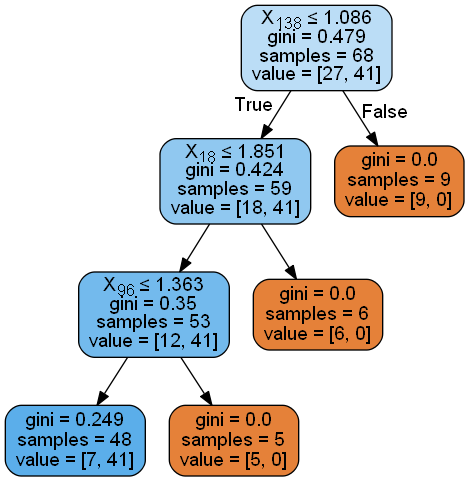

In [189]:
dot_data = StringIO()
export_graphviz(dt, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [137]:
X = X_phaseI_unimodal[features].fillna(NAFILL)
Y = Y_phaseI

In [278]:
classification_results = []
label = 0
test = -1
leafNo = -1
for (idx_row, row), test in zip(X.iterrows(), Y):
    if row.iloc[2] <= -0.138:
        if (row.iloc[4] <= 1.258):
            if (row.iloc[3] <= 0.605):
                label = 1
                leafNo = 1
            else:
                label = -1
                leafNo = 2

        else:
            label = -1
            leafNo = 3
    else:
        if (row.iloc[5] <= -0.175):
            label = -1
            leafNo = 4
        else:
            if (row.iloc[6] <= 0.212):
                label = 1
                leafNo = 5
            else:
                label = -1
                leafNo = 6
    classification_results.append([label, leafNo, test])

In [279]:
[]

[]

In [280]:
pd.pivot_table(pd.DataFrame(classification_results), index = [1,0,2], aggfunc = lambda x : len(x))

1  0   2    
1   1  False     1
       True     36
2  -1  False     3
3  -1  False     5
       True      1
4  -1  False    13
       True      1
5   1  True      6
6  -1  False     2
dtype: int64

### Tricks from the beginning - Out of curiosity

In [155]:
cols_full = [x for x in df_phaseI_select.columns.tolist()[5:] if ("_allday" not in x and "_dis_" not in x)]
df_unimodal_full = df_phaseI_select[["PID"] + cols_full]
df_unimodal_full_mean = df_unimodal_full.groupby("PID").mean()
df_unimodal_full_mean.columns = ["mean_" + y for y in cols_full]
df_unimodal_full_std = df_unimodal_full.groupby("PID").std()
df_unimodal_full_std.columns = ["std_" + y for y in cols_full]
df_unimodal_full_mean_std = df_unimodal_full_mean.merge(df_unimodal_full_std, how = "outer", left_index=True, right_index=True)
df_unimodal_full_mean_std = (df_unimodal_full_mean_std-df_unimodal_full_mean_std.mean())/df_unimodal_full_mean_std.std()
X_phaseI_unimodal_full = deepcopy(df_unimodal_full_mean_std)
X_phaseI_unimodal_full = X_phaseI_unimodal_full.loc[df_label.index]
Y_phaseI = df_label["label_I"]

cols_full = [x for x in df_phaseII_select.columns.tolist()[5:] if ("_allday" not in x and "_dis_" not in x)]
df_unimodal_full = df_phaseII_select[["PID"] + cols_full]
df_unimodal_full_mean = df_unimodal_full.groupby("PID").mean()
df_unimodal_full_mean.columns = ["mean_" + y for y in cols_full]
df_unimodal_full_std = df_unimodal_full.groupby("PID").std()
df_unimodal_full_std.columns = ["std_" + y for y in cols_full]
df_unimodal_full_mean_std = df_unimodal_full_mean.merge(df_unimodal_full_std, how = "outer", left_index=True, right_index=True)
df_unimodal_full_mean_std = (df_unimodal_full_mean_std-df_unimodal_full_mean_std.mean())/df_unimodal_full_mean_std.std()
X_phaseII_unimodal_full = deepcopy(df_unimodal_full_mean_std)
X_phaseII_unimodal_full = X_phaseII_unimodal_full.loc[df_label.index]
Y_phaseII = df_label["label_II"]


In [157]:
training_unimoal_full_results_depth = {}
training_unimoal_full_results_leaf = {}
for n_estimators in [5]:
    training_unimoal_full_results_depth[n_estimators] = {}
    training_unimoal_full_results_leaf[n_estimators] = {}
    print("depth")
    for max_depth in [2,3,4]:
        print(n_estimators,max_depth)
        r = adaboost(X_phaseI_unimodal_full.fillna(NAFILL),X_phaseII_unimodal_full.fillna(NAFILL),Y_phaseI,Y_phaseII,n_estimators,max_depth=max_depth)
        training_unimoal_full_results_depth[n_estimators][max_depth] = deepcopy(r)
    print("leaf")
    for max_leaf in [3,4,5,6,7,8]:
        print(n_estimators,max_leaf)
        r = adaboost(X_phaseI_unimodal_full.fillna(NAFILL),X_phaseII_unimodal_full.fillna(NAFILL),Y_phaseI,Y_phaseII,n_estimators,max_leaf_nodes=max_leaf)
        training_unimoal_full_results_leaf[n_estimators][max_leaf] = deepcopy(r)
with open(focus_path + "unimodal_full_train_result.pkl", "wb") as f:
    pickle.dump({"depth":training_unimoal_full_results_depth,"leaf":training_unimoal_full_results_leaf},f)

depth
5 2
(68, 1688)
[ 435  736  855 1279]
train acc  0.8878402107111499  test acc  0.7205882352941176
(68, 4)
train acc phase1:  0.8825724319578576 test acc phase1:  0.8382352941176471 phase2:  0.6029411764705882
5 3
(68, 1688)
[ 125  212  435  504  640  736  839  855  879  890  926  965 1119 1279
 1677 1684]
train acc  0.9855136084284458  test acc  0.5882352941176471
(68, 16)
[ 1  2  3  5  6  7  8  9 10 12 13 14 15]
train acc  0.9822212467076381  test acc  0.8235294117647058
(68, 13)
[ 0  1  2  3  5  6  7  8  9 10 12]
train acc  0.9822212467076381  test acc  0.8088235294117647
(68, 11)
train acc phase1:  0.9822212467076381 test acc phase1:  0.8088235294117647 phase2:  0.4852941176470588
5 4
(68, 1688)
[  17  284  736  855 1279 1398 1684]
train acc  1.0  test acc  0.6176470588235294
(68, 7)
train acc phase1:  1.0 test acc phase1:  0.8235294117647058 phase2:  0.5441176470588235
leaf
5 3
(68, 1688)
[ 435  736 1279]
train acc  0.8573309920983317  test acc  0.75
(68, 3)
train acc phase1: 

## Contextually Filtered

In [44]:
X_phaseI_contextual = pd.read_csv(focus_path + "X_contextual_phaseI.csv")
X_phaseI_contextual = X_phaseI_contextual.set_index("PID")
Y_phaseI = df_phaseI_label[~df_phaseI_label["BDI"].isna()]["label"]
X_phaseII_contextual = pd.read_csv(focus_path + "X_contextual_phaseII.csv")
X_phaseII_contextual = X_phaseII_contextual.set_index("PID")
Y_phaseII = df_phaseII_label[~df_phaseII_label["BDI"].isna()]["label"]

In [45]:
X_phaseI_contextual.shape

(68, 324)

In [46]:
training_contextual_results_depth = {}
training_contextual_results_leaf = {}
for n_estimators in [5]:
    training_contextual_results_depth[n_estimators] = {}
    training_contextual_results_leaf[n_estimators] = {}
    print("depth")
    for max_depth in [2,3,4]:
        print(n_estimators,max_depth)
        r = train_test("adaboost",
            X_phaseI_contextual.fillna(NAFILL),
            X_phaseII_contextual.fillna(NAFILL),
            Y_phaseI,
            Y_phaseII,
            n_estimators,
            max_depth=max_depth)
        training_contextual_results_depth[n_estimators][max_depth] = deepcopy(r)
    print("leaf")
    for max_leaf in [3,4,5,6,7,8]:
        print(n_estimators,max_leaf)
        r = train_test("adaboost",
            X_phaseI_contextual.fillna(NAFILL),
            X_phaseII_contextual.fillna(NAFILL),
            Y_phaseI,
            Y_phaseII,
            n_estimators,
            max_leaf_nodes=max_leaf)
        training_contextual_results_leaf[n_estimators][max_leaf] = deepcopy(r)
# with open(focus_path + "contextual_train_result.pkl", "wb") as f:
#     pickle.dump({"depth":training_contextual_results_depth,"leaf":training_contextual_results_leaf},f)

depth
5 2
(68, 324)
9, 11, 13, 15, 16, 17, 18, 18, 20, 20, 21
[321 261 262 264 271 147  83  87 158  31 222 228 231  41 174 240 241 243
 179 312 316]
train acc  0.8360403863037752  test acc  0.5  test acc bal  0.4242424242424242
(68, 21)
7
[ 1  5  8 13 14 16 17]
train acc  0.8312115891132572  test acc  0.6911764705882353  test acc bal  0.6477272727272727
(68, 7)
7
train acc phase1:  0.8303336259877084 test acc phase1:  0.6617647058823529   0.6060606060606061 phase2:  0.6029411764705882   0.556910569105691
5 3
(68, 324)
21, 28, 34, 39, 43, 45, 48, 49, 51, 54, 55
[256 258   3 260 261   7   9  11 139 268 270 271 269 147 275 276 151  25
  27 158  31 288 163 292  38 294  41  45 174 302 179 308  53 182  52 312
 315 317 321  72  82  87  96  97 228 230 231 233 237 240 241 243 250 123
 255]
train acc  0.9571992976294995  test acc  0.3235294117647059  test acc bal  0.3162878787878788
(68, 55)
21
[ 1  2  7  9 13 15 16 17 19 20 21 23 26 28 29 31 36 50 51 52 54]
train acc  0.9521510096575945  test a

## Hybrid Features

In [49]:
X_phaseI_hybrid = X_phaseI_unimodal.merge(X_phaseI_contextual, left_index=True, right_index=True)
Y_phaseI = df_phaseI_label[~df_phaseI_label["BDI"].isna()]["label"]
X_phaseII_hybrid = X_phaseII_unimodal.merge(X_phaseII_contextual, left_index=True, right_index=True)
Y_phaseII = df_phaseII_label[~df_phaseII_label["BDI"].isna()]["label"]

In [50]:
X_phaseI_hybrid.shape

(68, 481)

In [51]:
training_hybrid_results_depth = {}
training_hybrid_results_leaf = {}
for n_estimators in [5]:
    training_hybrid_results_depth[n_estimators] = {}
    training_hybrid_results_leaf[n_estimators] = {}
    print("depth")
    for max_depth in [2,3,4]:
        print(n_estimators,max_depth)
        r = train_test("adaboost",
            X_phaseI_hybrid.fillna(NAFILL),
            X_phaseII_hybrid.fillna(NAFILL),
            Y_phaseI,
            Y_phaseII,
            n_estimators,
            max_depth=max_depth)
        training_hybrid_results_depth[n_estimators][max_depth] = deepcopy(r)
    print("leaf")
    for max_leaf in [3,4,5,6,7,8]:
        print(n_estimators,max_leaf)
        r = train_test("adaboost",
            X_phaseI_hybrid.fillna(NAFILL),
            X_phaseII_hybrid.fillna(NAFILL),
            Y_phaseI,
            Y_phaseII,
            n_estimators,
            max_leaf_nodes=max_leaf)
        training_hybrid_results_leaf[n_estimators][max_leaf] = deepcopy(r)
with open(focus_path + "hybrid_train_result.pkl", "wb") as f:
    pickle.dump({"depth":training_hybrid_results_depth,"leaf":training_hybrid_results_leaf},f)

depth
5 2
(68, 481)
4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4
[ 97 115  52  31]
train acc  0.8988147497805093  test acc  0.4852941176470588  test acc bal  0.42234848484848486
(68, 4)
4
train acc phase1:  0.8955223880597015 test acc phase1:  0.75   0.7026515151515151 phase2:  0.5882352941176471   0.5826558265582655
5 3
(68, 481)
19, 30, 40, 48, 55, 63, 69, 74, 83, 90, 97
[257   2 259   4   5 262   1 264 265  10  11  14  16  17 275 279  24  25
 282 285  31  34 292  37  44  45  46  47 306  52  53 309  56  58  59  62
  68 327  76  80  84 346  91  97 107 364 367 115 373 122 378 381 126 128
 131 387 133 135 397 142 399 401 403 406 151 409 412 421 422 171 427 431
 176 433 181 183 185 190 191 447 198 455 456 201 458 463 212 472 476 224
 229 231 233 236 237 243 248]
train acc  0.9835381913959613  test acc  0.5441176470588235  test acc bal  0.5056818181818181
(68, 97)
16
[10 20 23 26 29 35 36 43 46 51 64 68 69 70 73 90]
train acc  0.9850746268656714  test acc  0.75  test acc bal  0.731060606060606
(68, 16